In [46]:
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from pydantic import BaseModel, Field

from dotenv import load_dotenv
import operator

In [19]:
# now try to build **state** for Essay LLM-workflow

class EssayState(TypedDict):
  essay_text: str 
  cot_feedback: str 
  doa_feedback: str 
  lang_feedback: str
  summary_feedback:str 

  evaluation_score: Annotated[list[float], operator.add]
  final_score: float

In [20]:
#use models which can give structured outputs like -> gpt-4o-mini
from langchain_openai import ChatOpenAI

load_dotenv()

model= ChatOpenAI(model="gpt-4o-mini")

## make an schema which we tell this model that which structure i want out to be

class EvaluationSchema(BaseModel):
  feedback: str= Field(description="Detailed feedback for the essay")
  score: float= Field(description="Score out of 100", ge=0, le=100)

structured_mode= model.with_structured_output(EvaluationSchema)

## or use pydantic output parser (see below)

In [ ]:
# globle llm model
llm= HuggingFaceEndpoint(
  repo_id="mistralai/Mistral-7B-Instruct-v0.2",
  task="chat-completions",
  huggingfacehub_api_token= os.getenv("HUGGINGFACEHUB_API_TOKEN")
)

model= ChatHuggingFace(llm= llm)

## now try to build fn for COT(clearity of thought) node in graph

def cot(state:EssayState):

  class CotOutcome(BaseModel):
    cot_feedback: str= Field(description="Feedback about 'Clearity of Thought' on Essay")
    cot_score: float= Field(description="Evaluation score on Essay about 'Clearity of Thought' in out of 0 to 100", ge=0, le=100)

  parser= PydanticOutputParser(pydantic_object=CotOutcome)

  # prompt= PromptTemplate(
  #   template="Evaluate the Essay -> {essay_text} \n in the basis of 'Clearity of thought' and give output according to this format -> \n {format_instructions}",
  #   input_variables=['essay_text'],
  #   partial_variables={"format_instructions": parser.get_format_instructions()}
  # )

  prompt= ChatPromptTemplate.from_messages([
    ("system", "Return ONLY valid JSON matching the schema"),
    ("human",
     "Evaluate the Essay -> {essay_text} \n in the basis of 'Clearity of thought'\n\n"
     "{format_instructions}"
     )
  ])

  prompt= prompt.partial(
    format_instructions= parser.get_format_instructions()
  )

  global model

  chain= prompt|model|parser 

  cot_feed_score= chain.invoke(state)

  print("cot_feed_score", cot_feed_score.cot_score)

  return {"cot_feedback": cot_feed_score.cot_feedback, "evaluation_score": [cot_feed_score.cot_score]}

## note need to send list of score then only reducer will add it in the state



## now try to build a fn for DOA(depath of analysis) node

def doa(state:EssayState):

  class DoaOutcome(BaseModel):
    doa_feedback: str= Field(description="Feedback about 'Depath of Analysis' on Essay")
    doa_score: float= Field(description="Evaluate score on Essay about 'Depath of Analysis' in out of 0 to 100", ge=0, le=100)

  parser= PydanticOutputParser(pydantic_object= DoaOutcome)

  # prompt= PromptTemplate(
  #   template="Evaluate the essay -> {essay_text} \n on the basis of 'Depath of Analysis' and give the outcome according to this format -> \n {format_instructions}",
  #   input_variables=['essay_text'],
  #   partial_variables={"format_instructions":parser.get_format_instructions()}
  # )

  prompt= ChatPromptTemplate.from_messages([
    ('system', "Return ONLY valid JSON matching the schema"),
    ("human", "Evaluate the Essay -> {essay_text} \n in the basis of 'Depath of Analysis'\n\n"
     "format instructions -> {format_instructions}")
  ])

  prompt= prompt.partial(
    format_instructions= parser.get_format_instructions()
  )

  global model

  chain= prompt|model|parser

  doa_feed_score= chain.invoke(state)

  print("doa_feed_score", doa_feed_score.doa_score)

  return {"doa_feedback":doa_feed_score.doa_feedback, "evaluation_score":[doa_feed_score.doa_score]}


# let try to build a fn for language evaluator node
def lang(state:EssayState):
  class LangOutcome(BaseModel):
    lang_feedback: str= Field(description="Feedback about 'Language' on Essay")
    lang_score: float= Field(description="Evaluate score on Essay about 'Language' in out of 0 to 100", ge=0, le=100)

  parser= PydanticOutputParser(pydantic_object=LangOutcome)

  # prompt= PromptTemplate(
  #   template="Evaluate the essay -> {essay_text} \n on the basis of 'Language' and give the outcome according to this format -> \n {format_instructions}",
  #   input_variables=['essay_text'],
  #   partial_variables={"format_instructions": parser.get_format_instructions()}
  # )

  prompt= ChatPromptTemplate.from_messages([
    ("system","Return ONLY valid JSON matching the schema"),
    ("human", "Evaluate the Essay -> {essay_text} \n in the basis of 'Language'\n\n"
     "format instructions -> {format_instructions}")
  ])

  prompt= prompt.partial(format_instructions= parser.get_format_instructions())

  global model 

  chain= prompt|model|parser 

  lang_feed_score= chain.invoke(state) 

  print("lang_feed_score", lang_feed_score.lang_score)

  return {"lang_feedback": lang_feed_score.lang_feedback, "evaluation_score":[lang_feed_score.lang_score]}

# now try to build a fn on summary node

def summary(state:EssayState):
  
  parser= StrOutputParser()

  prompt= PromptTemplate(
    template="Generate a summary about clearity of thought -> {cot_feedback}, \n Depath of analysis ->{doa_feedback} \n and language -> {lang_feedback}",
    input_variables=['cot_feedback',"doa_feedback", "lang_feedback"]
  )

  global model

  chain= prompt|model|parser 

  summary_feed= chain.invoke(state)
  eva_score= sum(state['evaluation_score'])/len(state['evaluation_score'])

  return {"summary_feedback": summary_feed, "final_score":eva_score}


  

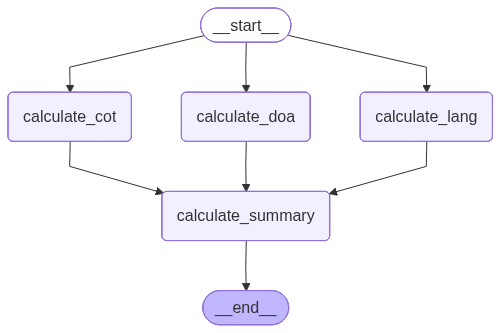

In [60]:
## Build a graph
graph= StateGraph(EssayState)

## add nodes
graph.add_node("calculate_cot", cot)
graph.add_node('calculate_doa', doa)
graph.add_node('calculate_lang', lang)
graph.add_node('calculate_summary', summary)

## add edges
graph.add_edge(START, "calculate_cot")
graph.add_edge(START, "calculate_doa")
graph.add_edge(START, "calculate_lang")

graph.add_edge("calculate_cot", "calculate_summary")
graph.add_edge("calculate_doa", "calculate_summary")
graph.add_edge("calculate_lang", "calculate_summary")

graph.add_edge("calculate_summary", END)


# compile the graph
workflow= graph.compile()
workflow

In [61]:
intial_state= {
  "essay_text":"""
Essay on Cat

A cat is a small, furry domestic animal that is loved by people all over the world. Cats are known for their soft fur, sharp eyes, and playful nature. They are usually kept as pets because they are friendly, clean, and easy to take care of.

Cats are very active and curious animals. They like to jump, run, and play with small objects like balls, strings, or toys. During the day, cats often spend their time sleeping, but at night they become more energetic. Their sharp claws and strong teeth help them protect themselves and catch small animals.

A cat is also a very clean animal. It spends a lot of time licking its body to keep itself clean. Cats are intelligent and can understand their owner’s voice and mood. They show affection by rubbing against people or sitting near them.

Cats are helpful to humans because they keep rats and mice away from homes. They are gentle companions and help reduce stress by their calm and loving behavior. Many people feel happy and relaxed when they are with their pet cat.

In conclusion, a cat is a cute, intelligent, and loving animal. It is a wonderful pet and a good friend to humans.
"""
}

final_state= workflow.invoke(intial_state)
final_state

cot_feed_score 90.0
summary_feedback 95.0
doa_feed_score 90.0


{'essay_text': '\nEssay on Cat\n\nA cat is a small, furry domestic animal that is loved by people all over the world. Cats are known for their soft fur, sharp eyes, and playful nature. They are usually kept as pets because they are friendly, clean, and easy to take care of.\n\nCats are very active and curious animals. They like to jump, run, and play with small objects like balls, strings, or toys. During the day, cats often spend their time sleeping, but at night they become more energetic. Their sharp claws and strong teeth help them protect themselves and catch small animals.\n\nA cat is also a very clean animal. It spends a lot of time licking its body to keep itself clean. Cats are intelligent and can understand their owner’s voice and mood. They show affection by rubbing against people or sitting near them.\n\nCats are helpful to humans because they keep rats and mice away from homes. They are gentle companions and help reduce stress by their calm and loving behavior. Many people